# 主要目标
在机器学习平台Amazon SageMaker中，基于机器学习框架MXNet，使用自己收集的数据在一个预训练的图像分类模型上使用迁移学习，构建一个具有较高准确率的汽车型号分类器。
# 架构图
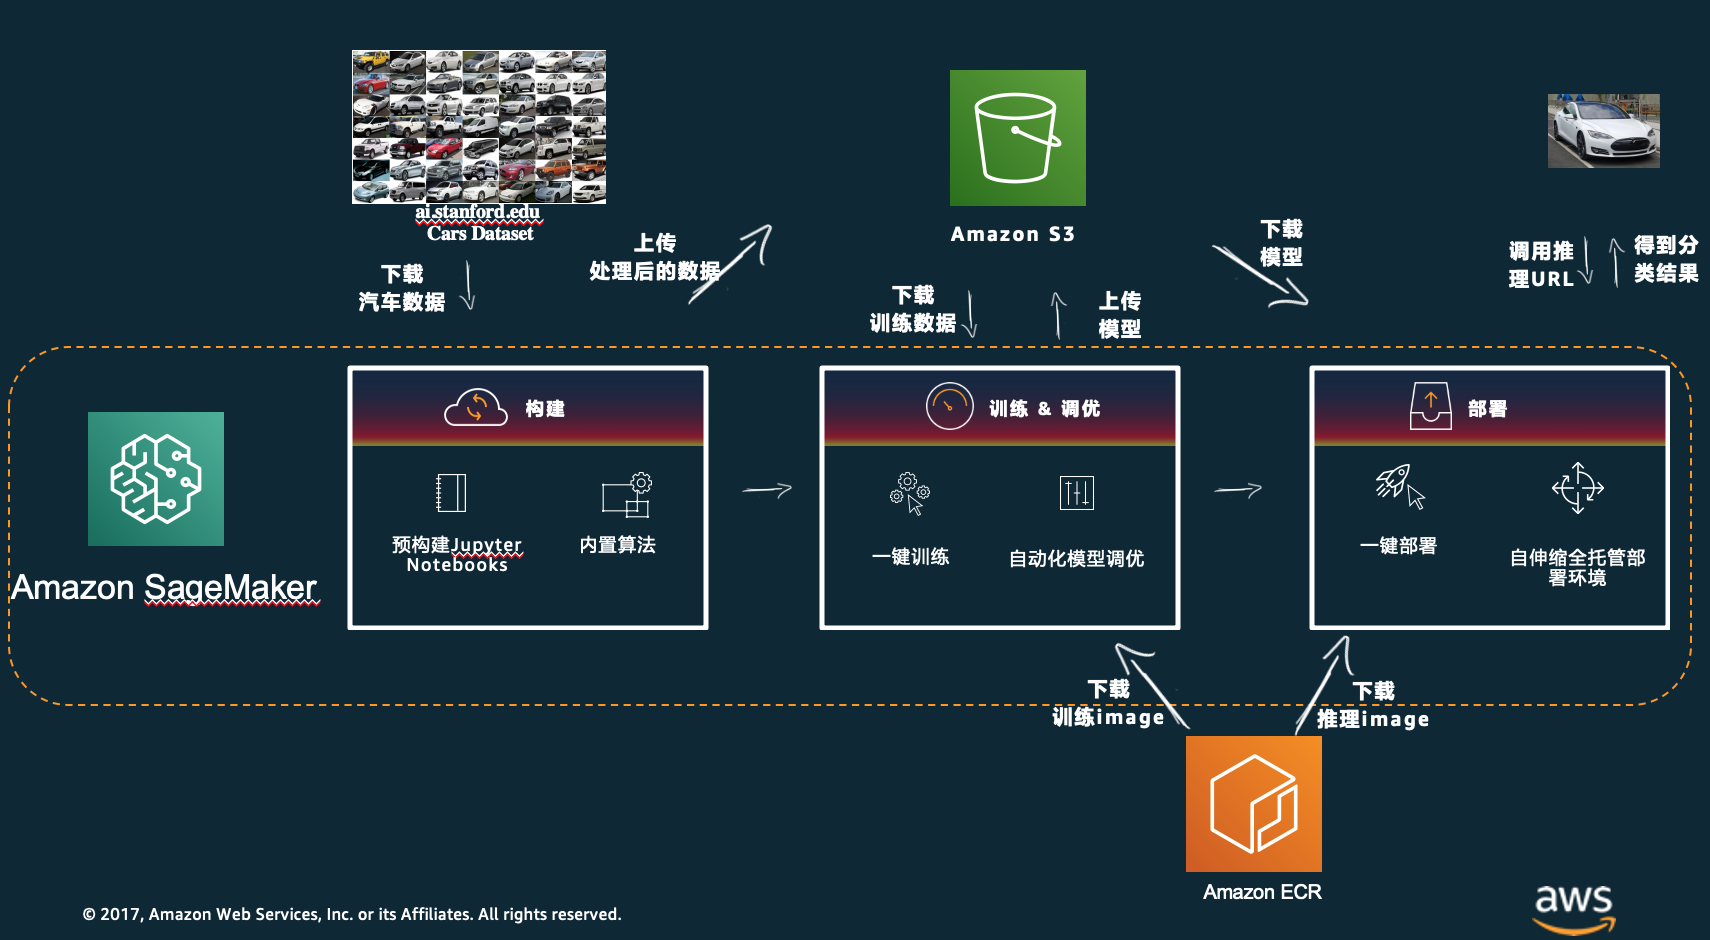

# Step1: 创建存放训练数据和模型的S3存储桶
<kbd>用时约1分钟</kbd> <br />
登录到AWS Console，切换区域到“美国东部 (弗吉尼亚北部)us-east-1”，在S3服务中创建一个存储桶，如cars-classifier-xxxxx.(xxxxx请使用随机数字字母串代替)
记录下这个存储桶的名字

# Step2: 创建笔记本实例
<kbd>用时约3分钟</kbd> <br />
登录到AWS Console，切换区域到“美国东部 (弗吉尼亚北部)us-east-1”，在SageMaker服务中创建一个笔记本实例，按默认”创建 IAM 角色“,笔记本实例类型根据需要可选”ml.m5.xlarge“;<br />
等待该笔记本实例创建完成，状态由”Pending“变为”InService“，点击后面的链接”打开 Jupyter“即可进入Jupyter

# Step3：下载并预处理数据

<kbd>用时约3分钟</kbd> <br />
本次演示的训练数据截取自斯坦福大学提供的开源数据集"Cars"数据集，该数据集包含 16,185 张 196 种汽车的图像。数据分为 8,144 个训练图像和 8,041 个测试图像，每个类大致拆分为一半训练一半测试。通常按制造，模型，年份分类，例如2012年特斯拉模型S或2012宝马M3轿跑车（2012 Tesla Model S or 2012 BMW M3 coupe）。<br /> 
出于演示目的，本次演示的训练数据只截取了3种车型的图片，共120张：<br />
Acura Integra Type R 2001，45张图片<br />
Acura RL Sedan 2012，32张图片<br />
Acura TL Sedan 2012，43张图片<br />

获取数据

In [ ]:
%%bash

wget https://shishuai-share-external.s3.cn-north-1.amazonaws.com.cn/script/im2rec.py
wget https://sagemaker-sample-dataset-bjs.s3.cn-north-1.amazonaws.com.cn/car_data_sample.zip
unzip car_data_sample.zip

mkdir train
mkdir validation
data_path=car_data_sample 
echo "data_path: ${data_path}" 
train_path=train/ 
echo "train_path: ${train_path}" 
val_path=validation/ 
echo "val_path: ${val_path}"

python im2rec.py --list --train-ratio 0.8 --recursive $data_path/data $data_path/train

python im2rec.py --resize 224 --center-crop --num-thread 4 $data_path/data $data_path/train

mv ${data_path}/data_train.rec $train_path
mv ${data_path}/data_val.rec $val_path

# Step4.环境准备，上传处理后的数据到S3存储桶
<kbd>用时约1分钟</kbd> <br />
创建一些使用AWS服务所需的授权和环境。包含三部分：<br /> 
(1)模型训练所需的权限， 这个会自动从创建笔记本的role中自动获取 <br /> 
(2)指定存储训练数据和模型的S3存储桶 <br /> 
(3)Amazon Sagemaker 中预训练好的图像分类模型docker image<br /> 

最后上传处理后的数据到S3存储桶，然后可以到S3控制台上检查是否成功上传。

In [ ]:
%%time
!pwd
import boto3
import re
import os 

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
print(role)
sess = sagemaker.Session()
role = get_execution_role()

bucket = sess.default_bucket()
prefix = 'car-classifier'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
print(training_image)
     
def upload_to_s3(file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = file
    s3.Bucket(bucket).put_object(Key=key, Body=data)
    print('Upload {}/{} successful'.format(bucket,key))


# upload to S3 bucket
s3_train_key = "train"
s3_validation_key = "validation"
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)

upload_to_s3('train/data_train.rec')
upload_to_s3('validation/data_val.rec')


# Step5.使用迁移学习进行模型训练
<kbd>用时约6分钟</kbd> <br />
数据集准备结束之后，我们就可以开始模型的训练了。但在开始训练任务之前， 我们需要配置模型训练的一系列超参数，具体的超参数含义如下：
```
Num_layers： 神经网络的层数，本例中可以选择18, 34, 50, 101, 152 and 200。很多经典网络模型的名字中包含的数字就代表了layer个数，如vgg16中的16就代表了权重层的个数
Image_shape： 输入图像的通道数，像素的长宽
Num_training_samples： 训练样本的个数
Num_classes: 训练样本图像分类的类目数，本例中为了简介，只选取了三个class做范例
mini_batch_size： 每轮训练的输入一批数据包含的数目
epochs： 训练轮次
learning_rate： 训练学习率
use_pretrained_model： 是否使用预训练模型进行迁移学习，如为1，则初始化中使用已经基于一个较大的开源数据集训练好的模型，如基于数据集imagenet上的ResNet模型，学习的网络结构
```

之后，我们进行必要的 SageMaker API 的创建，构建对应的训练任务 – 其中有指定训练的输入与输出，训练的计算实例配置，这里，我们使用的是 ml.p3.2xlarge GPU 实例。需要注意的是，这里sagemaker notebook进行本地的数据处理，模型训练，模型推理是不同的环境，可以根据不同的计算任务的需求进行不同的机型选择。

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
ic = sagemaker.estimator.Estimator(training_image,
                                     role, 
                                     train_instance_count=1, 
                                     train_instance_type='ml.p3.2xlarge',
                                     train_volume_size = 50,
                                     train_max_run = 360000,
                                     input_mode= 'File',
                                     output_path=s3_output_location,
                                     sagemaker_session=sess)

In [ ]:
ic.set_hyperparameters(num_layers=18,
                         image_shape = "3,224,224",
                         use_pretrained_model=1,
                         num_classes=3,
                         num_training_samples=96,
                         mini_batch_size=30,
                         epochs=100,
                         learning_rate=0.01,
                         top_k=2,
                         precision_dtype='float32')

In [ ]:
train_data = sagemaker.session.s3_input(s3_train, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

In [ ]:
ic.fit(inputs=data_channels, logs=True)

到这里，我们完成了启动训练任务。

完成上述步骤后，您可以在Sagemaker Console中看到自己的训练任务，当status为completed时，代表训练完成。整个训练过程大概持续6分钟，这个时间会根据选择的机型和设置的epochs个数等进行变化。<br />
同时，在训练过程中，您还可以通过监控cloudwatch logs来查看训练过程中的loss变化<br />
也可以在SageMaker控制台台上查看”历史记录“，如下
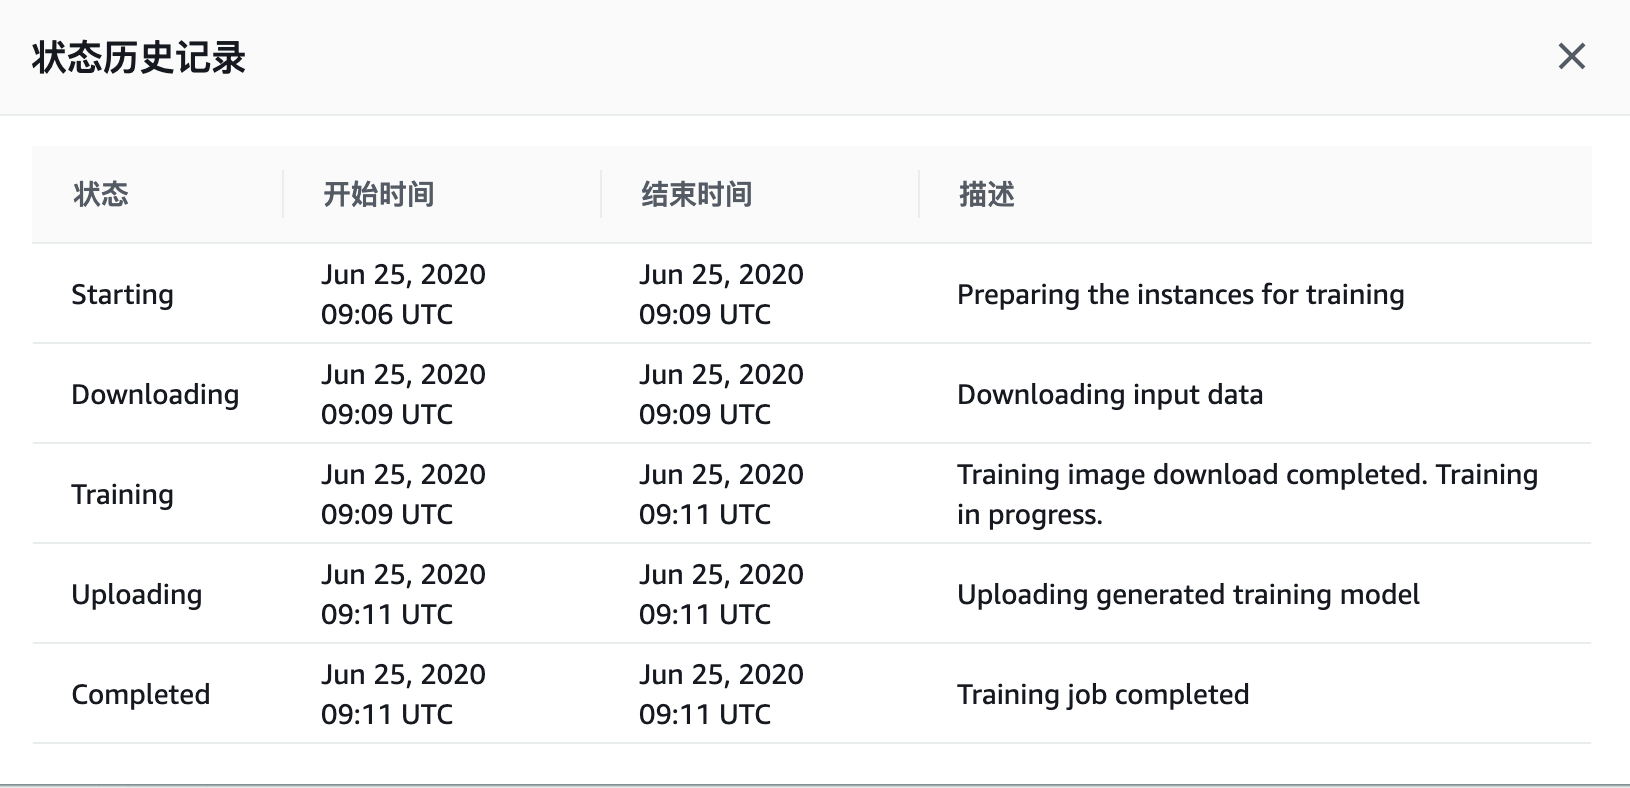

# Step6.模型部署
<kbd>用时约6分钟</kbd> <br />
训练结束后，我们在之前配置的S3存储桶就获得了最新的模型文件。我们接下来，将其进行线上部署，这样就可以通过接受来自客户端的Restful API请求进行预测。

In [ ]:
ic_classifier = ic.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# Step7. 推理及应用
<kbd>用时约2分钟</kbd> <br />
现在我们使用一个随意挑选的车的图片进行型号的分类。
我们直接调用创建的endpoint进行推理，可以看到结果与概率，可以看到，准确的判断出了相对应的分类。这里的概率并不是非常高，但鉴于我们作为范例只训练了不多的epoch，已经是个很不错的结果了。如果想要得到更高的准确率，请使用完整数据集进行更多轮次的训练。

In [ ]:
import random
from IPython.display import Image

car = 'Acura Integra Type R 2001/'
testls = os.listdir('car_data_sample/test/'+car)
file_name = 'car_data_sample/test/'+car+testls[random.randint(0,len(testls)-1)]

# test image
Image(file_name)  

In [ ]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic_classifier.content_type = 'application/x-image'
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

以上就是一个完整的使用Amazon Sagemaker构建图像分类模型，训练，部署的过程。您可以将它进行修改，完成不同场景下自己的图像分类任务，同时，我们后续还会推出，使用Sagemaker进行目标检测等不同场景的图像任务应用的实现方式，敬请关注。

# 最后一步,清除资源
<kbd>用时约1分钟</kbd> <br />
完成测试后，清除访问端点资源

In [ ]:
ic_classifier.delete_endpoint()